<a href="https://colab.research.google.com/github/jobint001/Fake_news_detection/blob/main/fakenews_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size ="4">**Importing all the libraries**</font>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import nltk
import os
import pickle
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.linear_model import LogisticRegression
import time
import numpy as np

[nltk_data] Downloading package punkt to /home/u185842/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u185842/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer

<font size ="4">**Downloading the dataset and extracting it to the appropriate data directory.**</font>

In [3]:
data_directory = 'data/'
if not os.path.exists(data_directory):
    !mkdir data/
    !wget https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip --directory-prefix=data/
    !unzip data/News-_dataset.zip -d data/

<font size="4">**Read the data csv file**</font>

In [4]:
fake_data = pd.read_csv('data/Fake.csv',low_memory=False)


In [5]:
true_data = pd.read_csv('data/True.csv',low_memory=False)



Assigning Classes to the Dataset

In [6]:
true_data["label"] = 1
fake_data["label"] = 0

Merging Both the Dataset

In [7]:
data = pd.concat([true_data, fake_data], axis=0)

## User defined function for data-visualization

Visualization of the text data based on subject column

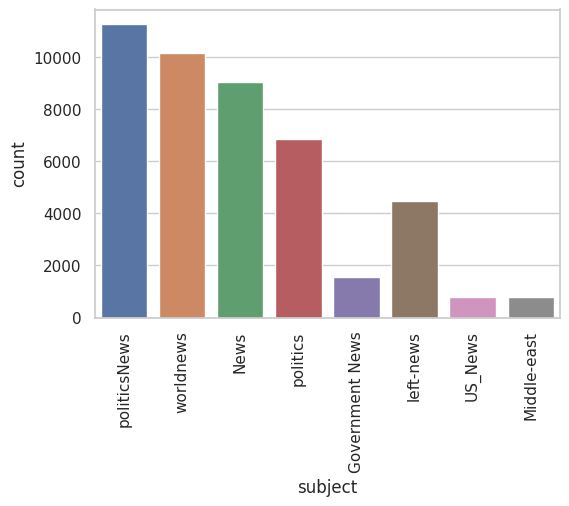

In [8]:
plt.figure(figsize = (6,4))
sns.set(style = "whitegrid",font_scale = 1.0)
chart = sns.countplot(x = "subject", data = data)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
plt.show()

<font size="4">**Data preprocessing**</font>

In [9]:
data['text'] = data['title'] +' '+data['text']
# Either you could data.drop["column names"] or del data["column names"]
del data['title']
del data['subject']
del data['date']

In [10]:
data.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


As the title, author column will not going to be helpful in identification of the news. So, we can drop these column.

In [11]:
data.shape

(44898, 2)

In [12]:
#pip install WordCloud

In [13]:
def Check_forNAN(data):
    
    print("Wait...Checking for NANs in the Dataset is progressing...")
    print("Total NANs:",data.isnull().sum())
    data=data.dropna()
    print("Checking is completed successfully...\n")
    print(10*"--","\n")
    print("Summary of the dataframe:......\n")
    data.info()
        
    print("check finished.")

Check if there is any null value (If so, then we will drop those rows)

In [14]:
Check_forNAN(data)

Wait...Checking for NANs in the Dataset is progressing...
Total NANs: text     0
label    0
dtype: int64
Checking is completed successfully...

-------------------- 

Summary of the dataframe:......

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   label   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB
check finished.


 Now we have to shuffle the dataset to prevent the model to get bias

In [15]:
#Shuffling the data by sampling it randomly, then resetting the index and dropping the previous index column
data = data.sample(frac=1).reset_index(drop=True)
data.head()


,text,label
0,Missouri Republican Calls Getting Pregnant Th...,0
1,"Smaller EU states need stronger voice, not Bru...",1
2,Meet The CA Sheriff Who Won’t Be Bullied By Ob...,0
3,Trump team weighs 'infrastructure bank' to fun...,1
4,Trump says U.S. deal with Russia on Syria will...,1


Now Let’s explore the unique values in the each category using below code.

<Axes: xlabel='label', ylabel='count'>

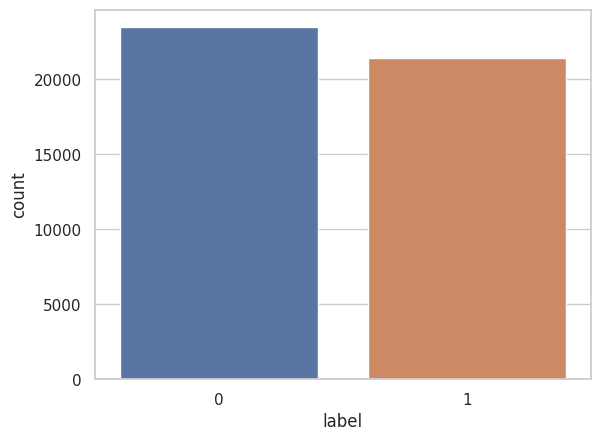

In [16]:
sns.countplot(data=data,
              x='label',
              order=data['label'].value_counts().index)

<font size="5">**Data Cleaning**</font>

Once we have all the required modules, we can create a function name preprocess text. This function will preprocess all the data given as input.

### Tokenizing

In [17]:
def tokenize(column):
    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()] 

### Removing stopwords

In [18]:
from nltk.corpus import stopwords

In [19]:
def remove_stopwords(tokenized_column):
    stops = set(stopwords.words("english"))
    return [word for word in tokenized_column if not word in stops]

### Stemming

In [20]:
def apply_stemming(tokenized_column):
    stemmer = PorterStemmer() 
    return [stemmer.stem(word) for word in tokenized_column]

### Rejoining 

In [21]:
def rejoin_words(tokenized_column):  
    return ( " ".join(tokenized_column))

In [22]:
def cleaning(news): 
    
    test_news={"text":[news]}
    input_data=pd.DataFrame(test_news)
      
    input_data['tokenized'] = input_data.apply(lambda x: tokenize(x["text"]), axis=1)
    input_data['stopwords_removed'] = input_data.apply(lambda x: remove_stopwords(x['tokenized']), axis=1)
    input_data['stemmed'] = input_data.apply(lambda x: apply_stemming(x['stopwords_removed']), axis=1)
    input_data['rejoined'] = input_data.apply(lambda x: rejoin_words(x['stemmed']), axis=1)
    A = input_data['rejoined']
    return A

In [23]:
print(type(data["text"]))

<class 'pandas.core.series.Series'>


<font>**Calling cleaning function**</font>

In [24]:
start=time.time()
#data['text'] = data['text'].str.decode(encoding = 'UTF-8')
data['text'] = data['text'].apply(cleaning)
tot_t=time.time()-start
print("Time for cleaning :",tot_t)
data.head()

Time for cleaning : 350.75090980529785


,text,label
0,missouri republican call get pregnant the silv...,0
1,smaller eu state need stronger voic brussel sa...,1
2,meet the ca sheriff who won be bulli by obama ...,0
3,trump team weigh bank fund project trump advis...,1
4,trump say deal russia syria save mani live han...,1


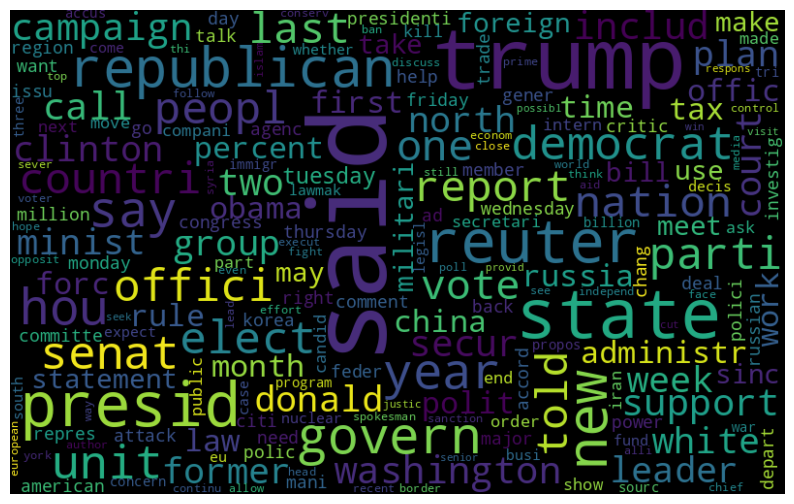

In [25]:
from wordcloud import WordCloud
fake_data = data[data['label'] == 1]
all_words = ' '.join([text for text in fake_data.text])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Spliting the dataframe into data and label

In [26]:
data.label = data.label.astype(str)
data['label'].head()

0    0
1    1
2    0
3    1
4    1
Name: label, dtype: object

In [27]:
X = data['text']


In [28]:
y = data['label']

## Vectorization

In [29]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
count_vectorizer = CountVectorizer()


In [30]:
start=time.time()
count_vectorizer.fit_transform(X)
freq_term_matrix = count_vectorizer.transform(X)
tfidf = TfidfTransformer(norm = "l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)
tot_t=time.time()-start
print('Time taken :',tot_t)
print(tf_idf_matrix)

Time taken : 11.640075922012329
  (0, 74746)	0.029021406754207998
  (0, 74037)	0.06007302381541147
  (0, 73852)	0.09121188465969816
  (0, 73703)	0.026951286264799056
  (0, 73398)	0.03312374155798939
  (0, 72881)	0.029321910011476878
  (0, 72538)	0.022277309669644578
  (0, 71391)	0.02210012860092665
  (0, 70760)	0.07860103604022486
  (0, 70643)	0.047563142572302125
  (0, 68121)	0.045886330655550804
  (0, 67351)	0.1086477696080849
  (0, 66981)	0.09514851869131134
  (0, 66644)	0.022738536169828846
  (0, 66639)	0.04890037285051174
  (0, 66602)	0.021002551450315626
  (0, 66520)	0.04612840711404142
  (0, 66487)	0.045048719851242584
  (0, 66313)	0.011179227541507646
  (0, 65204)	0.03057359193623773
  (0, 65196)	0.01978532298880137
  (0, 64525)	0.03564677202742905
  (0, 64249)	0.0454604415703113
  (0, 63178)	0.04656122523901698
  (0, 62170)	0.08270876767979979
  :	:
  (44897, 17221)	0.0819845041291202
  (44897, 15651)	0.14223998423087503
  (44897, 15263)	0.24134148234464672
  (44897, 14054)	0.

In [31]:
pickle.dump(tfidf,open('./tfidf_vectorizer.pkl', 'wb'))

In [32]:
from scipy.sparse import save_npz

# Assuming you have the TF-IDF matrix stored in the variable 'tf_idf_matrix'
save_npz('tf_idf_matrix.npz', tf_idf_matrix)


In [33]:
from scipy.sparse import load_npz

# Load the TF-IDF matrix from the file
tf_idf_matrix = load_npz('tf_idf_matrix.npz')

## Splitting data for training and test

In [34]:
x_train, x_test, y_train, y_test = train_test_split(tf_idf_matrix,y, random_state=21)

<font size="4">**Model training, Evaluation, and Prediction**</font>

## Fake-news detection using ML

### 1. Logistic Regression

In [35]:
y_train
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    mean_squared_error,accuracy_score, f1_score


<font>*Using unpatched sklearn library*</font>

In [36]:
#logit model
#Using unpatched sklearn module
from sklearnex import unpatch_sklearn
unpatch_sklearn()
from sklearn.linear_model import LogisticRegression

t=time.time()
logitmodel = LogisticRegression()
logitmodel.fit(x_train, y_train)
y_pred=logitmodel.predict(x_test)
Accuracy = logitmodel.score(x_test, y_test)

print("Accuracy",Accuracy*100)

tot_t=time.time()-t

print("Time taken:",tot_t)


Accuracy 98.9042316258352
Time taken: 4.735078573226929


In [37]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [38]:
y_pred1=logitmodel.predict(x_train)
mse = mean_squared_error(y_train, y_pred1)
rmse = sqrt(mse)
print("RMSE of Logit model-training:",rmse)

RMSE of Logit model-training: 0.0858192935638827


In [39]:
print(classification_report(y_test, y_pred.astype(str)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5843
           1       0.99      0.99      0.99      5382

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



<font>*Using patched sklearn library*</font>

In [40]:
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.linear_model import LogisticRegression

params = {
    'C': 0.1,
    'solver': 'lbfgs',
    'multi_class': 'multinomial',
    'n_jobs': -1,
}
start = time.time()

classifier = LogisticRegression(**params).fit(x_train, y_train)
Accuracy = classifier.score(x_test, y_test)

print("Accuracy",Accuracy*100)
train_patched = time.time() - start
f"Intel® extension for Scikit-learn time: {train_patched:.2f} s"

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Accuracy 97.97772828507794


'Intel® extension for Scikit-learn time: 3.32 s'

In [41]:
y_predict = classifier.predict(x_test)


In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predict)
print(cm)

[[5723  120]
 [ 107 5275]]


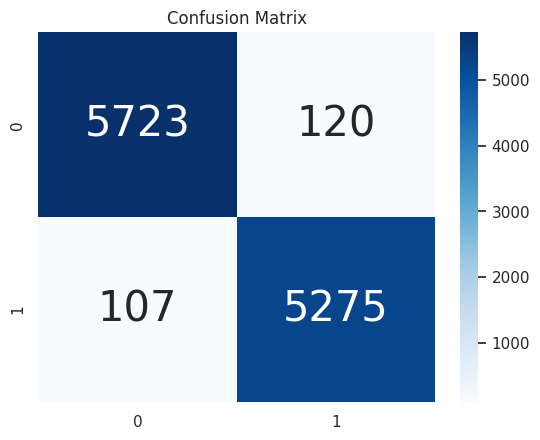

In [43]:
# confusion matrix sns heatmap 
cm = confusion_matrix(y_test, y_predict)
ax = plt.axes()
df_cm = cm
sns.heatmap(df_cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

<font size="4">**ROC curve**</font>

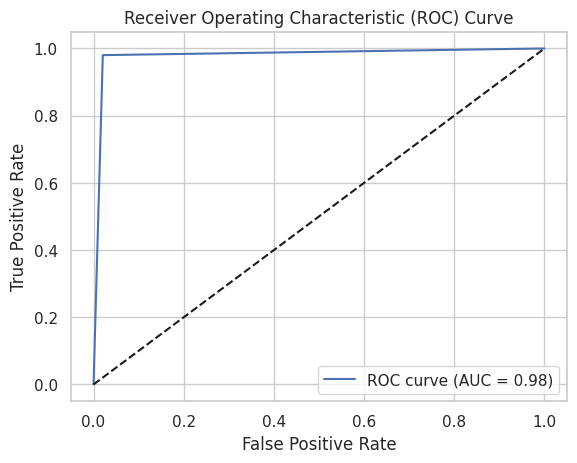

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'y_true' contains the true labels and 'y_scores' contains the predicted probabilities or decision scores for the positive class of a single model


y_true=y_test.to_numpy()
y_true = y_true.astype(str)
y_pred1 = y_predict.astype(float)

fpr, tpr, thresholds = roc_curve(y_true, y_pred1,pos_label='1')
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()


### 2. Naive Bayes classification model

In [45]:
#NB
from sklearn.naive_bayes import MultinomialNB
t=time.time()
NB = MultinomialNB()
NB.fit(x_train, y_train)
y_pred=NB.predict(x_test)
Accuracy = NB.score(x_test, y_test)
print("Accuracy",Accuracy*100)

tot_t=time.time()-t

print("Time taken:",tot_t)


Accuracy 93.55902004454343
Time taken: 0.16910934448242188


In [46]:
mse = mean_squared_error(y_test, y_pred.astype(int))
rmse = sqrt(mse)
print("RMSE of NB model-testing:",rmse)

RMSE of NB model-testing: 0.2537908579018671


In [47]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.96      0.94      5843
           1       0.95      0.91      0.93      5382

    accuracy                           0.94     11225
   macro avg       0.94      0.93      0.94     11225
weighted avg       0.94      0.94      0.94     11225



<font size="4">**ROC curve**</font>

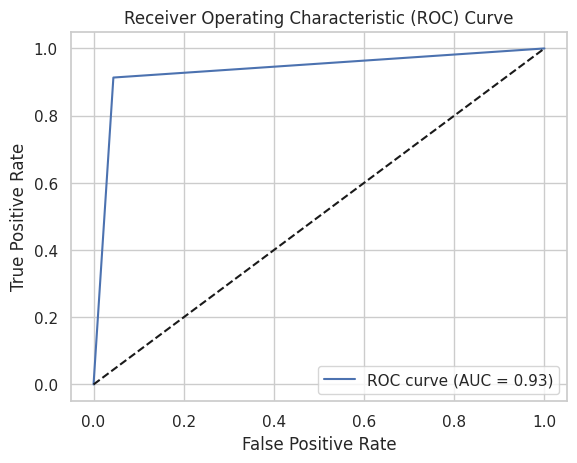

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'y_true' contains the true labels and 'y_scores' contains the predicted probabilities or decision scores for the positive class of a single model


y_true=y_test.to_numpy()
y_true = y_true.astype(str)
y_pred1 = y_pred.astype(int)

fpr, tpr, thresholds = roc_curve(y_true, y_pred1,pos_label='1')
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

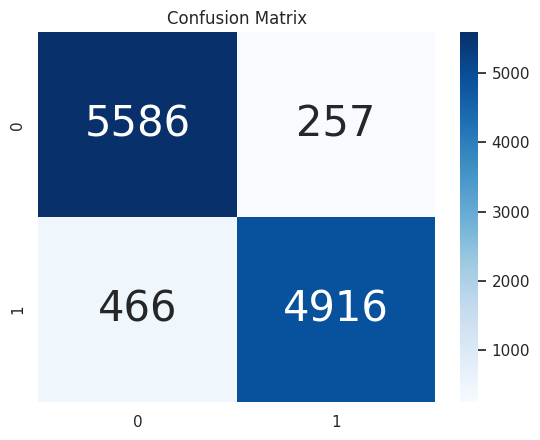

In [49]:
cm = confusion_matrix(y_test, y_pred)
ax = plt.axes()
df_cm = cm
sns.heatmap(df_cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

### 3. Decision Tree

In [50]:
from sklearn.tree import DecisionTreeClassifier
t=time.time()
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
Accuracy = clf.score(x_test, y_test)
print("Accuracy",Accuracy*100)

tot_t=time.time()-t
print("Time taken:",tot_t)

Accuracy 99.62583518930957
Time taken: 23.042919397354126


In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5843
           1       1.00      1.00      1.00      5382

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [52]:
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE of DT model-testing:",rmse)

RMSE of DT model-testing: 0.061169012636335986


<font size="4">**ROC curve**</font>

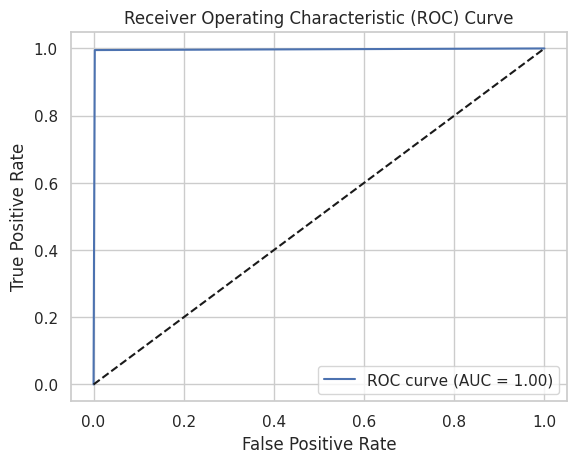

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'y_true' contains the true labels and 'y_scores' contains the predicted probabilities or decision scores for the positive class of a single model


y_true=y_test.to_numpy()
y_true = y_true.astype(str)
y_pred1 = y_pred.astype(float)

fpr, tpr, thresholds = roc_curve(y_true, y_pred1,pos_label='1')
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

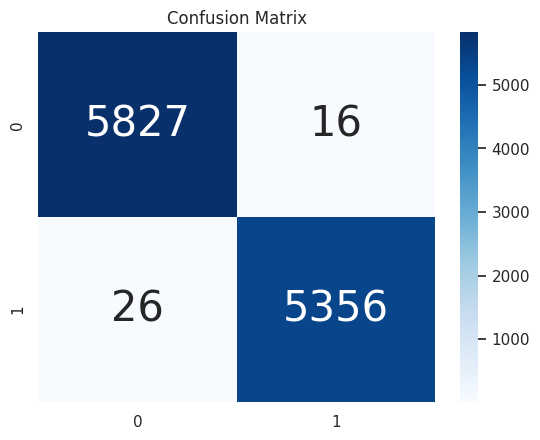

In [54]:
cm = confusion_matrix(y_test, y_pred)
ax = plt.axes()
df_cm = cm
sns.heatmap(df_cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

### 4. Passive-Aggressive Classifier

In [55]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
start=time.time()
pac.fit(x_train,y_train)

PassiveAggressiveClassifier(max_iter=50)

In [56]:
#Predict on the test set and calculate accuracy
y_pred=pac.predict(x_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')
tot_t=time.time()-start

print("Time taken:",tot_t)



Accuracy: 99.58%
Time taken: 0.42796850204467773


In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5843
           1       1.00      0.99      1.00      5382

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [58]:
mse = mean_squared_error(y_test, y_pred.astype(int))
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.06470766882947655


<font size="4">**ROC curve**</font>

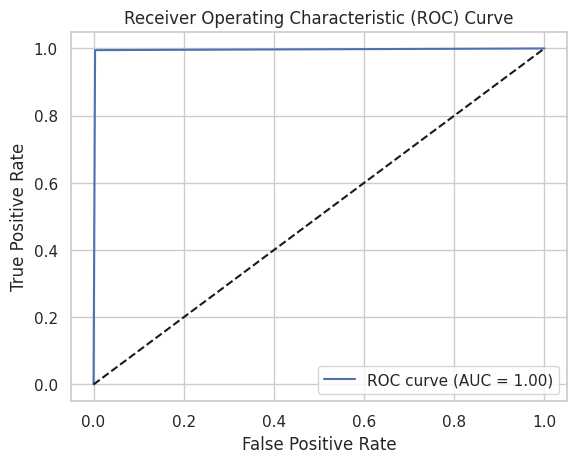

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'y_true' contains the true labels and 'y_scores' contains the predicted probabilities or decision scores for the positive class of a single model


y_true=y_test.to_numpy()
y_true = y_true.astype(str)
y_pred1 = y_pred.astype(float)

fpr, tpr, thresholds = roc_curve(y_true, y_pred1,pos_label='1')
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

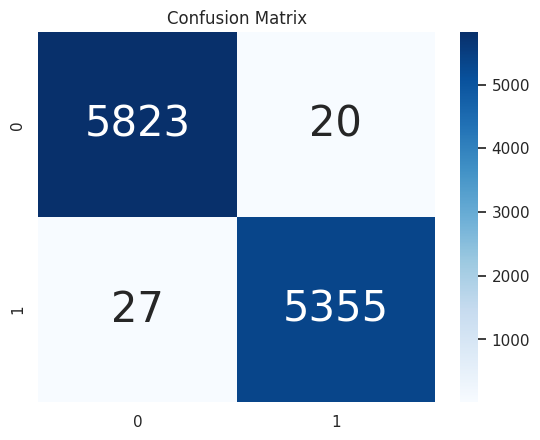

In [60]:
cm = confusion_matrix(y_test, y_pred)
ax = plt.axes()
df_cm = cm
sns.heatmap(df_cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

<font size="4">**Saving model-Passive-Aggressive Classifier**</font>

In [61]:
pickle.dump(pac,open('./selected_model.pkl', 'wb'))

In [62]:
# load the model from disk
loaded_model = pickle.load(open('./selected_model.pkl', 'rb'))

<font size="4">**Using the saved model for fake-news prediction from a new data**</font>

In [63]:
def fake_news_det(news):
    review = cleaning(news)
    
    freq_term_matrix1 = count_vectorizer.transform(review)
    tfidf1 = TfidfTransformer(norm = "l2")
    tfidf1.fit(freq_term_matrix)
    tf_idf_matrix1 = tfidf1.transform(freq_term_matrix)
   
    prediction=loaded_model.predict(tf_idf_matrix1)
   
    if prediction[0] == '0':
        print("Prediction of the News :  Looking Fake⚠ News📰 ")
    else:
        print("Prediction of the News : Looking Real News📰 ")

In [64]:
if __name__ == '__main__':
    news=input("Enter the news article:")
    
    fake_news_det(news)

Enter the news article: Just when you might have thought we d get a break from watching people kiss Donald Trump s ass and stroke his ego ad nauseam, a pro-Trump group creates an ad that s nothing but people doing even more of those exact things. America First Policies is set to release this ad, called  Thank You, President Trump,  on Christmas Day and, well, we threw up a little in our mouths trying to watch this.Basically, the spot is nothing but people fawning all over Trump for all the stuff he hasn t actually done. The ad includes a scene with a little girl thanking Trump for bringing back  Merry Christmas,  which never went away (there are even videos of President Obama saying  Merry Christmas  himself). A man thanks him for cutting his taxes. And America First says that everyday Americans everywhere are thanking Trump for being such a great and awesome president.The best president.Nobody s ever done what he s done. He s breaking all kinds of records every day.Believe us.Anyway, 

Prediction of the News :  Looking Fake⚠ News📰 


<font size=4>**Running a small model with feature extraction**</font>

In [65]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# N features with highest chi-squared statistics are selected
chi2_features = SelectKBest(chi2, k = 1000)
X_small = chi2_features.fit_transform(tf_idf_matrix, y)

In [66]:
x_train, x_test, y_train, y_test = train_test_split(X_small,y, random_state=21)

In [67]:
print(x_train.shape)
print(x_test.shape)

(33673, 1000)
(11225, 1000)


In [68]:
#logit short model
#from sklearn.linear_model import LogisticRegression
time_start = time.time()
logitmodel = LogisticRegression()
logitmodel.fit(x_train, y_train)
y_pred=logitmodel.predict(x_test)
Accuracy = logitmodel.score(x_test, y_test)
print(Accuracy*100)
print('Logit Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

98.5924276169265
Logit Model done! Time elapsed: 0.31060290336608887 seconds


In [69]:
y_pred=logitmodel.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE of Logit small model-testing:",rmse)

RMSE of Logit small model-testing: 0.11864115572066451


In [70]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5843
           1       0.98      0.99      0.99      5382

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [71]:
from sklearn.naive_bayes import MultinomialNB
time_start = time.time()
NB = MultinomialNB()
NB.fit(x_train, y_train)
y_pred=NB.predict(x_test)
Accuracy = NB.score(x_test, y_test)
print(Accuracy*100)
print('NB Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

94.39643652561247
NB Model done! Time elapsed: 0.13140296936035156 seconds


In [72]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5843
           1       0.95      0.93      0.94      5382

    accuracy                           0.94     11225
   macro avg       0.94      0.94      0.94     11225
weighted avg       0.94      0.94      0.94     11225



In [73]:
y_pred =y_pred.astype(float)

In [74]:
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE of NB model-testing:",rmse)

RMSE of NB model-testing: 0.23671847148854963


In [75]:
from sklearn.tree import DecisionTreeClassifier
time_start = time.time()
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
Accuracy = clf.score(x_test, y_test)
print(Accuracy*100)
print('DT Model done! Time elapsed: {} seconds'.format(time.time()-time_start))


99.456570155902
DT Model done! Time elapsed: 7.030956506729126 seconds


In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5843
           1       0.99      0.99      0.99      5382

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [77]:
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE of DT model-testing:",rmse)

RMSE of DT model-testing: 0.07371769421909474


In [78]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import PassiveAggressiveClassifier
time_start = time.time()
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(x_train,y_train)
y_pred=pac.predict(x_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')
print('PAC Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

Accuracy: 99.47%
PAC Model done! Time elapsed: 0.13502097129821777 seconds


In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5843
           1       0.99      0.99      0.99      5382

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [80]:
y_pred =y_pred.astype(float)

In [81]:
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE of PAC model-testing:",rmse)

RMSE of PAC model-testing: 0.07311095390768581
